#Heart Failure Prediction 

https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

- drive 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- module import 

In [2]:
!pip install colorama

In [3]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.10.0)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from colorama import Fore, Back, Style 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.formula.api import ols
import plotly.graph_objs as gobj

import plotly.figure_factory as ff

%matplotlib inline

from IPython.display import Image
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
#colab 내부에서 그래프 띄우기 위함
import plotly.io as pio
pio.renderers.default = 'colab'

In [6]:
!pip install catboost

In [63]:
import xgboost
import lightgbm
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

- 데이터 확인

In [8]:
heart = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/heart_failure_clinical_records_dataset.csv')
heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [9]:
heart.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [10]:
heart.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000




* age : 나이 (40 - 95)
* anaemia : 빈혈 ( 0 - no , 1 - yes )
* creatinine_phosphokinase : 혈중 cpk (낮을수록 안좋음)
* diabetes : 당뇨병여부 ( 0 - no , 1 - yes )
* ejection_fraction : 심장의 기능 평가용 수치 (심장이 얼마나 혈액을 잘 짜주냐) 50-80% 정상
* high_blood_pressure : 고혈압여부 ( 0 - no , 1 - yes )
* platelets : 혈소판 (혈액 내에서 혈액 응고 및 지혈 작용에 중요한 역할) 130~400 정상
* serum_creatinine : 혈청크레아티닌 , 신장 기능을 측정하는 수치 (근육량 감소시 감소)
* serum_sodium : 혈청나트륨
* sex : 성별 ( 0 - 여 , 1 - 남 )
* smoking : 흡연여부 ( 0 - no , 1 -yes )
* time : 사망일 또는 퇴원일 - 사용하지 않을 것.
* DEATH_EVENT : 사망여부 ( 0 - no , 1 - yes )



In [11]:
# time col 제거
heart = heart.drop('time',axis=1)
heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,0


- 결측값 확인

In [12]:
heart.isnull().count()

age                         299
anaemia                     299
creatinine_phosphokinase    299
diabetes                    299
ejection_fraction           299
high_blood_pressure         299
platelets                   299
serum_creatinine            299
serum_sodium                299
sex                         299
smoking                     299
DEATH_EVENT                 299
dtype: int64

결측값 없음

# Analysis & Visualization
-https://datascienceschool.net/view-notebook/69b85ec9afb7415d8da4c8cd5e46d22e/

- 상관관계 파악 (Heatmap)

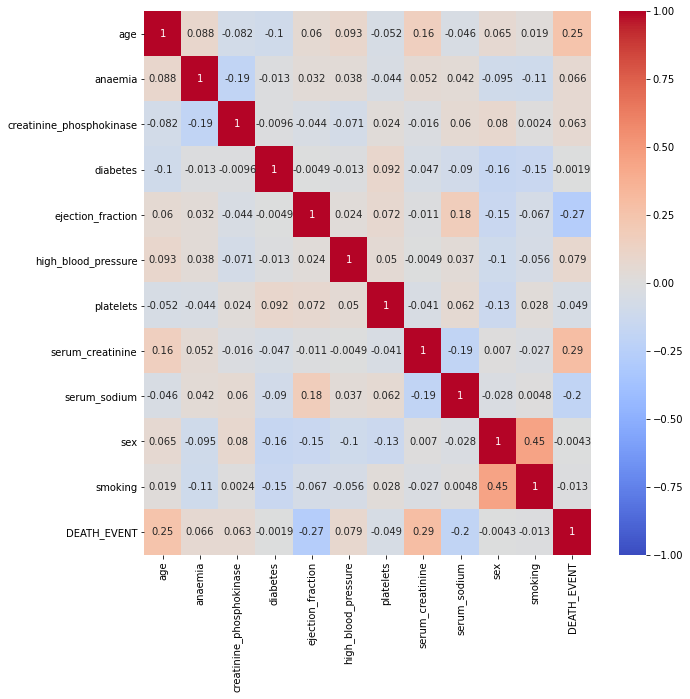

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(heart.corr(), vmin=-1, cmap='coolwarm', annot=True)

- age , serum_sodium , serum_creatinine , ejection_fraction


- 그려 볼 것

1.   age histo (전체 / 사망자 / 생존자)
2.   sex histo (전체 / 사망자 / 생존자)



1. age distribution (전체)

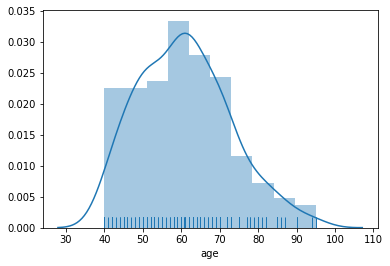

In [14]:
sns.distplot(heart.age, rug=True)
plt.show()

In [15]:
age_hist =[heart["age"].values]
age_group_labels = ['age'] 

age_fig = ff.create_distplot(age_hist, age_group_labels)
age_fig.update_layout(title_text='Age Distribution plot')

age_fig.show()

전체적으로 60대의 인원수가 가장 많았고 그 다음으로 50대, 70대, 40대 순으로 많은 비율을 차지한다.

1-1. age distribution (사망자)

In [16]:
death = heart[heart['DEATH_EVENT']==1]
death #96명

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.90,130,1,0,1
1,55.0,0,7861,0,38,0,263358.03,1.10,136,1,0,1
2,65.0,0,146,0,20,0,162000.00,1.30,129,1,1,1
3,50.0,1,111,0,20,0,210000.00,1.90,137,1,0,1
4,65.0,1,160,1,20,0,327000.00,2.70,116,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
220,73.0,0,582,0,20,0,263358.03,1.83,134,1,0,1
230,60.0,0,166,0,30,0,62000.00,1.70,127,0,0,1
246,55.0,0,2017,0,25,0,314000.00,1.10,138,1,0,1
262,65.0,1,258,1,25,0,198000.00,1.40,129,1,0,1


In [17]:
age_death = [death.age.values]
age_death_group_labels = ['age(death)'] 

age_death_fig = ff.create_distplot(age_death , age_death_group_labels)
age_death_fig.update_layout(title_text='Death Age Distribution plot')

age_death_fig.show()

사망자는 60대가 가장많고 (50대,70대 비교하려면 10대씩 구간 나눠서 봐야하지 않나?)

1-2. age distribute (생존자)

In [18]:
alive = heart[heart.DEATH_EVENT == 0]
alive #203명

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,DEATH_EVENT
14,49.0,1,80,0,30,1,427000.0,1.0,138,0,0,0
20,65.0,1,52,0,25,1,276000.0,1.3,137,0,0,0
23,53.0,0,63,1,60,0,368000.0,0.8,135,1,0,0
33,50.0,1,159,1,30,0,302000.0,1.2,138,0,0,0
38,60.0,0,2656,1,30,0,305000.0,2.3,137,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,0
295,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,0
296,45.0,0,2060,1,60,0,742000.0,0.8,138,0,0,0
297,45.0,0,2413,0,38,0,140000.0,1.4,140,1,1,0


In [19]:
age_alive = [alive.age.values]
age_alive_group_labels = ['age(alive)']

age_alive_fig = ff.create_distplot(age_alive ,age_alive_group_labels)
age_alive_fig.update_layout(title_text = 'Alive Age Distribution plot')

age_alive_fig.show()


생존자는 60대가 가장많고 그다음 50대, 70대 ,40대 순

2. sex distribution

In [20]:
sex_data = heart['sex'].value_counts().reset_index()
sex_data.columns = ['sex', 'count']
fig = px.bar(sex_data, x='sex', y="count", orientation='v', title='sex distribution', width=500)
fig.show()

In [21]:
#heart['gender'] = heart['sex'].replace(0,'W')
#heart['gender'] = heart['sex'].replace(1,'M')

In [22]:
fig = px.box(heart, x='sex', y='age', points="all")
fig.update_layout(
    title_text="Gender wise Age Spread - Male = 1 Female =0")
fig.show()

- age & sex

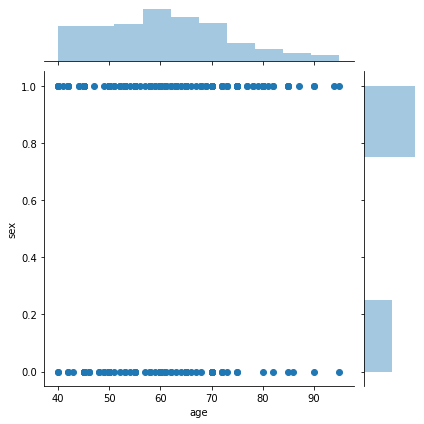

In [23]:
sns.jointplot(x="age", y="sex", data=heart)
plt.show()

In [24]:
fig = px.violin(heart, y="age", x="sex", color="DEATH_EVENT", box=True, points="all", hover_data=heart.columns)
fig.update_layout(title_text="Analysis in Age and Gender on Survival Status")
fig.show()

In [25]:
sun = heart.groupby(['sex', 'diabetes', 'smoking', 'DEATH_EVENT'])['age'].count().reset_index()
sun.columns = ['sex', 'diabetes', 'smoking', 'DEATH_EVENT', 'count']
sun.loc[sun['sex'] == 0, 'sex'] = 'female'
sun.loc[sun['sex'] == 1, 'sex'] = 'male'
sun.loc[sun['smoking'] == 0, 'smoking'] = "doesn't smoke"
sun.loc[sun['smoking'] == 1, 'smoking'] = 'smoke'
sun.loc[sun['diabetes'] == 0, 'diabetes'] = "no diabetes"
sun.loc[sun['diabetes'] == 1, 'diabetes'] = 'diabetes'
sun.loc[sun['DEATH_EVENT'] == 0,'DEATH_EVENT'] = "ALIVE_EVENT"
sun.loc[sun['DEATH_EVENT'] == 1, 'DEATH_EVENT'] = 'DEATH_EVENT'

In [26]:
sun

,sex,diabetes,smoking,DEATH_EVENT,count
0,female,no diabetes,doesn't smoke,ALIVE_EVENT,35
1,female,no diabetes,doesn't smoke,DEATH_EVENT,13
2,female,no diabetes,smoke,ALIVE_EVENT,1
3,female,no diabetes,smoke,DEATH_EVENT,1
4,female,diabetes,doesn't smoke,ALIVE_EVENT,35
5,female,diabetes,doesn't smoke,DEATH_EVENT,18
6,female,diabetes,smoke,DEATH_EVENT,2
7,male,no diabetes,doesn't smoke,ALIVE_EVENT,35
8,male,no diabetes,doesn't smoke,DEATH_EVENT,25
9,male,no diabetes,smoke,ALIVE_EVENT,47


In [27]:
fig = px.sunburst(sun, path=['sex','diabetes','smoking','DEATH_EVENT'], values='count', title='Sunburst chart for all patients', width=600,height=600)
fig.show()

# Modeling

- 전체 변수를 넣고 모델링 vs 선정한 4개의 변수로 모델링(age , serum_sodium , serum_creatinine , ejection_fraction)

1. 선정한 4개의 변수 모델링

In [123]:
#train & test set
Features = ['age','serum_sodium','ejection_fraction','serum_creatinine']
x_f = heart[Features]
y_f = heart["DEATH_EVENT"]
x_f_train,x_f_test,y_f_train,y_f_test = train_test_split(x_f,y_f, test_size=0.2, random_state=4)
# random_state 는 재현가능(for reproducibility)하도록 난수의 초기값을 설정해주는 것, 아무 숫자나 할당.
# shuffle = True 기본값 (시계열 처럼 순서가 중요한 경우 False 필수)

In [124]:
#logistic regression

accuracy_list_f = []

log_reg_f = LogisticRegression()
log_reg_f.fit(x_f_train, y_f_train)
log_reg_pred_f = log_reg_f.predict(x_f_test)
log_reg_acc_f = accuracy_score(y_f_test, log_reg_pred_f)
accuracy_list_f.append(100*log_reg_acc_f)

print(Fore.GREEN + "Accuracy of Logistic Regression in four columns is : ", "{:.2f}%".format(100* log_reg_acc_f))


Accuracy of Logistic Regression in four columns is :  75.00%


<Figure size 1440x576 with 0 Axes>

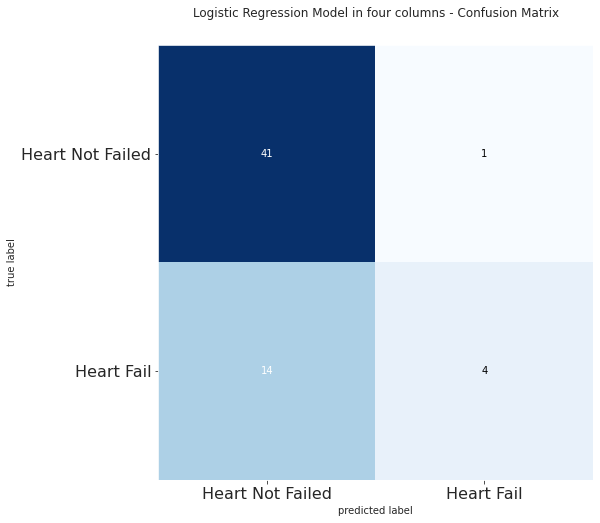

In [125]:
#check logistic regression result

cm_logi_f = confusion_matrix(y_f_test, log_reg_pred_f)
plt.figure()
plot_confusion_matrix(cm_logi_f , figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [126]:
# svc

sv_clf = SVC(kernel = 'poly',degree=3)
sv_clf.fit(x_f_train, y_f_train)
sv_clf_pred_f = sv_clf.predict(x_f_test)
sv_clf_acc_f = accuracy_score(y_f_test, sv_clf_pred_f)
accuracy_list_f.append(100* sv_clf_acc_f)

print(Fore.GREEN + "Accuracy of SVC in four col is : ", "{:.2f}%".format(100* sv_clf_acc_f))

Accuracy of SVC in four col is :  73.33%


<Figure size 1440x576 with 0 Axes>

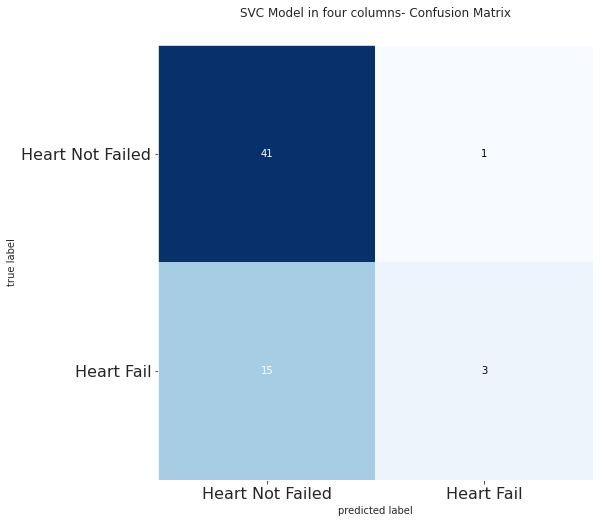

In [127]:
# check svc result

cm_svc_f = confusion_matrix(y_f_test, sv_clf_pred_f)
plt.figure()
plot_confusion_matrix(cm_svc_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVC Model in four columns- Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [128]:
# Decision Tree Classifier

dt_clf = DecisionTreeClassifier(max_leaf_nodes=8, random_state=4, criterion='entropy')
dt_clf.fit(x_f_train, y_f_train)
dt_pred_f = dt_clf.predict(x_f_test)
dt_acc_f = accuracy_score(y_f_test, dt_pred_f)
accuracy_list_f.append(100*dt_acc_f)

print(Fore.GREEN + "Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* dt_acc_f))

Accuracy of Decision Tree Classifier is :  71.67%


<Figure size 1440x576 with 0 Axes>

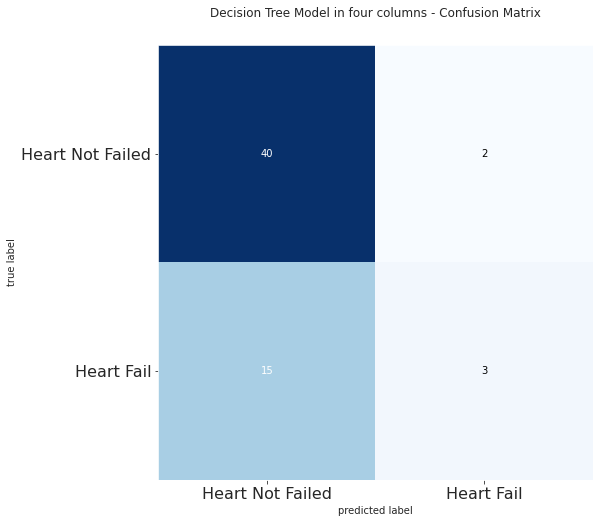

In [129]:
# check Decision Tree result

cm_dt_f = confusion_matrix(y_f_test, dt_pred_f)
plt.figure()
plot_confusion_matrix(cm_dt_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [130]:
# RandomForestClassifier


r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=4)
r_clf.fit(x_f_train, y_f_train)
r_pred_f = r_clf.predict(x_f_test)
r_acc_f = accuracy_score(y_f_test, r_pred_f)
accuracy_list_f.append(100*r_acc_f)
print(Fore.GREEN + "Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* r_acc_f))


Accuracy of Random Forest Classifier is :  70.00%


<Figure size 1440x576 with 0 Axes>

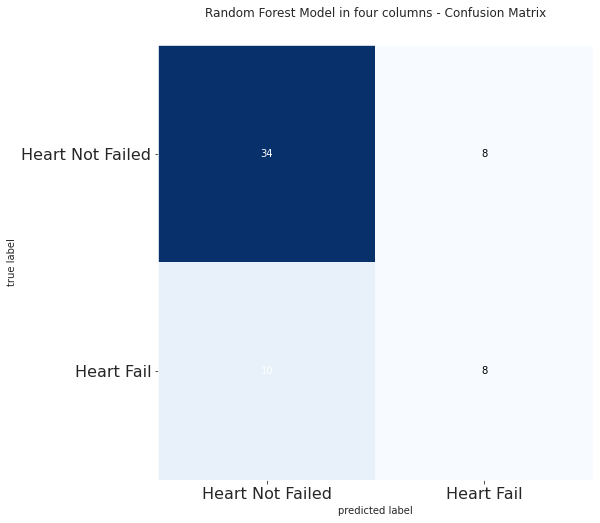

In [131]:
# check Random Forest result
cm_rf_f = confusion_matrix(y_f_test, r_pred_f)
plt.figure()
plot_confusion_matrix(cm_rf_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [132]:
# GradientBoostingClassifier

gradientboost_clf = GradientBoostingClassifier(max_depth=4, random_state=4)
gradientboost_clf.fit(x_f_train,y_f_train)
gradientboost_pred_f = gradientboost_clf.predict(x_f_test)
gradientboost_acc_f = accuracy_score(y_f_test, gradientboost_pred_f)
accuracy_list_f.append(100*gradientboost_acc_f)
print(Fore.GREEN + "Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc_f))

Accuracy of Gradient Boosting is :  63.33%


<Figure size 1440x576 with 0 Axes>

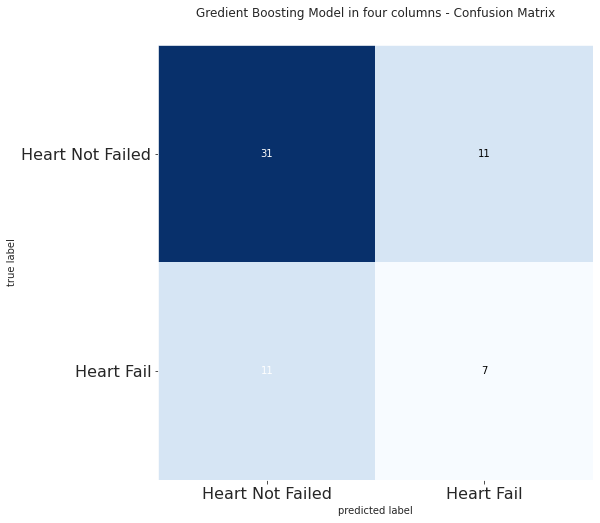

In [133]:
# check Gradient Boosting result

cm_gb_f = confusion_matrix(y_f_test, gradientboost_pred_f)
plt.figure()
plot_confusion_matrix(cm_gb_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [134]:
# xgbrf classifier

xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=4)
xgb_clf.fit(x_f_train,y_f_train)
xgb_pred_f = xgb_clf.predict(x_f_test)
xgb_acc_f = accuracy_score(y_f_test, xgb_pred_f)
accuracy_list_f.append(100*xgb_acc_f)
print(Fore.GREEN + "Accuracy of XGBRFClassifier is : ", "{:.2f}%".format(100* xgb_acc_f))

Accuracy of XGBRFClassifier is :  75.00%


<Figure size 1440x576 with 0 Axes>

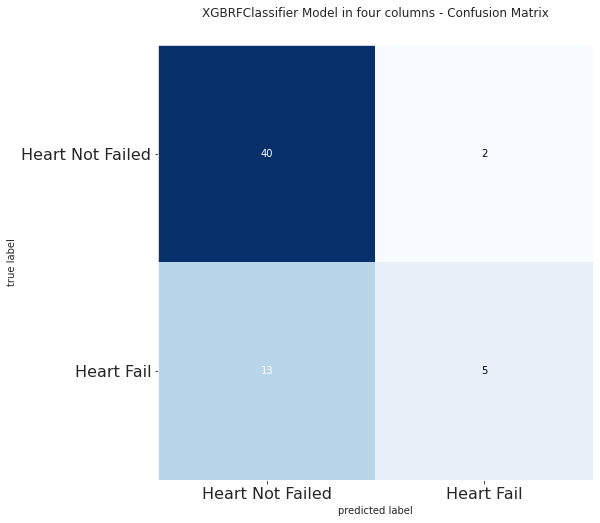

In [135]:
# check xgboost result

cm_xgb_f = confusion_matrix(y_f_test, xgb_pred_f)
plt.figure()
plot_confusion_matrix(cm_xgb_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [136]:
#  lightgbm 


lgb_clf = lightgbm.LGBMClassifier(max_depth=3, random_state=4)
lgb_clf.fit(x_f_train,y_f_train)
lgb_pred_f = lgb_clf.predict(x_f_test)
lgb_acc_f = accuracy_score(y_f_test, lgb_pred_f)
accuracy_list_f.append(100*lgb_acc_f)
print(Fore.GREEN + "Accuracy of LGBMClassifier is : ","{:.2f}%".format(100* lgb_acc_f))

Accuracy of LGBMClassifier is :  65.00%


<Figure size 1440x576 with 0 Axes>

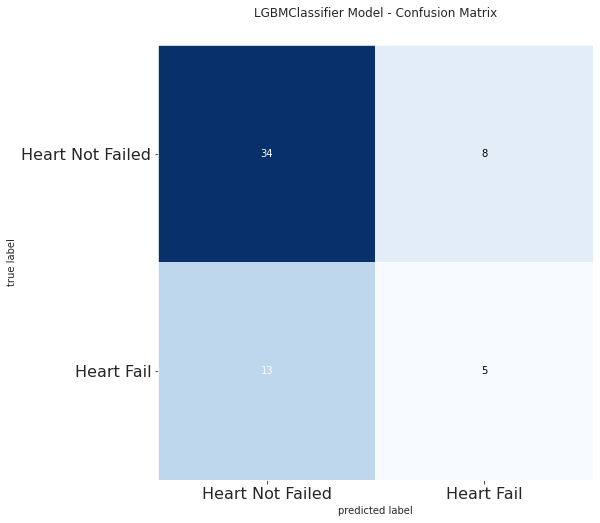

In [137]:
# check lightgbm result

cm_lgbm_f = confusion_matrix(y_f_test, lgb_pred_f)
plt.figure()
plot_confusion_matrix(cm_lgbm_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("LGBMClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [138]:
# adaboost (parameter 조절하기 위해 개념 공부 필요)
#https://blog.naver.com/dic1224/220989033563
#https://datascienceschool.net/view-notebook/7d82087c31d64fe491dc74e1d5953ca2/
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

adab_clf = AdaBoostClassifier(base_estimator=None , n_estimators=50, learning_rate=1.0, algorithm='SAMME.R',random_state=4)
adab_clf.fit(x_f_train,y_f_train)
adab_pred_f = adab_clf.predict(x_f_test)
adab_acc_f = accuracy_score(y_f_test, adab_pred_f)
accuracy_list_f.append(100*adab_acc_f)
print(Fore.GREEN + "Accuracy of Adaboost Classifier in four columns is : ","{:.2f}%".format(100* adab_acc_f))

Accuracy of Adaboost Classifier in four columns is :  66.67%


<Figure size 1440x576 with 0 Axes>

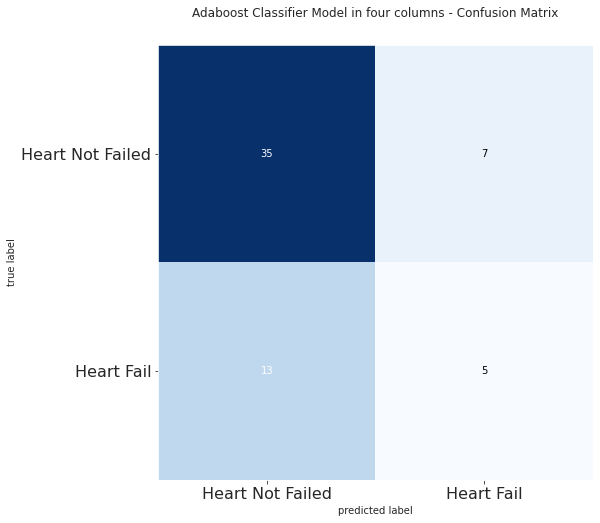

In [139]:
# check Adaboost Classifier result

cm_adab_f = confusion_matrix(y_f_test, adab_pred_f)
plt.figure()
plot_confusion_matrix(cm_adab_f, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Adaboost Classifier Model in four columns - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

- 그외 참고

grid search : https://stackabuse.com/grid-search-optimization-algorithm-in-python/

(grid search random search and bayesian optimization)

sigmoid (https://everyday-deeplearning.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EC%9C%BC%EB%A1%9C-%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%95%98%EA%B8%B0-%EC%8B%A0%EA%B2%BD%EB%A7%9D-%ED%99%9C%EC%84%B1%ED%99%94-%ED%95%A8%EC%88%98%EA%B3%84%EB%8B%A8-%EC%8B%9C%EA%B7%B8%EB%AA%A8%EC%9D%B4%EB%93%9C-ReLU-%ED%95%A8%EC%88%98)


- 모델 성능 비교

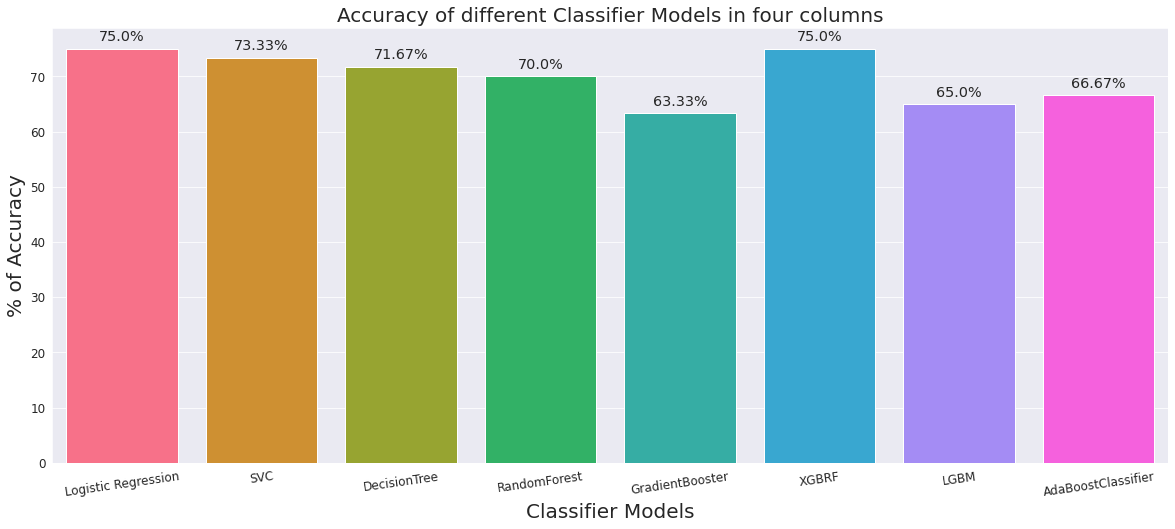

In [140]:
model_list = ['Logistic Regression', 'SVC', 'DecisionTree', 'RandomForest','GradientBooster', 'XGBRF','LGBM', 'AdaBoostClassifier']
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list_f, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models in four columns', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

2. 전체 변수 모델링

In [168]:
#train & test set
x = heart
y = heart["DEATH_EVENT"]
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [169]:
#logistic regression

accuracy_list = []

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
log_reg_pred = log_reg.predict(x_test)
log_reg_acc = accuracy_score(y_test, log_reg_pred)
accuracy_list.append(100*log_reg_acc)

print(Fore.GREEN + "Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* log_reg_acc))


Accuracy of Logistic Regression is :  75.00%


<Figure size 1440x576 with 0 Axes>

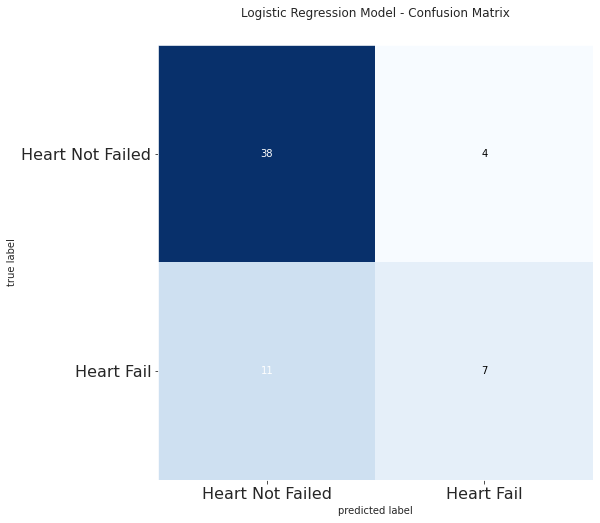

In [170]:
#check logistic regression result

cm_logi = confusion_matrix(y_test, log_reg_pred)
plt.figure()
plot_confusion_matrix(cm_logi , figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [171]:
# svc

sv_clf = SVC(kernel = 'poly',degree=3)
sv_clf.fit(x_train, y_train)
sv_clf_pred = sv_clf.predict(x_test)
sv_clf_acc = accuracy_score(y_test, sv_clf_pred)
accuracy_list.append(100* sv_clf_acc)

print(Fore.GREEN + "Accuracy of SVC in four col is : ", "{:.2f}%".format(100* sv_clf_acc))

Accuracy of SVC in four col is :  70.00%


<Figure size 1440x576 with 0 Axes>

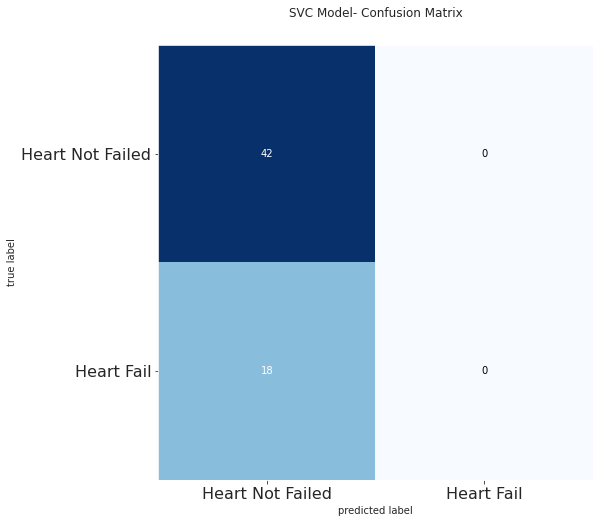

In [172]:
# check svc result

cm_svc = confusion_matrix(y_test, sv_clf_pred)
plt.figure()
plot_confusion_matrix(cm_svc, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("SVC Model- Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [173]:
# Decision Tree Classifier

dt_clf = DecisionTreeClassifier(max_leaf_nodes=8, random_state=4, criterion='entropy')
dt_clf.fit(x_train, y_train)
dt_pred = dt_clf.predict(x_test)
dt_acc = accuracy_score(y_test, dt_pred)
accuracy_list.append(100*dt_acc)

print(Fore.GREEN + "Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* dt_acc))


Accuracy of Decision Tree Classifier is :  100.00%


<Figure size 1440x576 with 0 Axes>

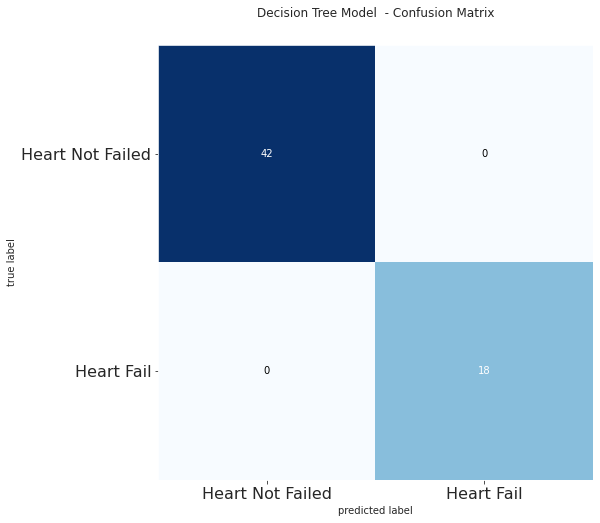

In [174]:
# check Decision Tree result

cm_dt = confusion_matrix(y_test, dt_pred)
plt.figure()
plot_confusion_matrix(cm_dt, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model  - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [175]:
# RandomForestClassifier


r_clf = RandomForestClassifier(max_features=0.5, max_depth=15, random_state=4)
r_clf.fit(x_train, y_train)
r_pred = r_clf.predict(x_test)
r_acc = accuracy_score(y_test, r_pred)
accuracy_list.append(100*r_acc)
print(Fore.GREEN + "Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* r_acc))


Accuracy of Random Forest Classifier is :  100.00%


<Figure size 1440x576 with 0 Axes>

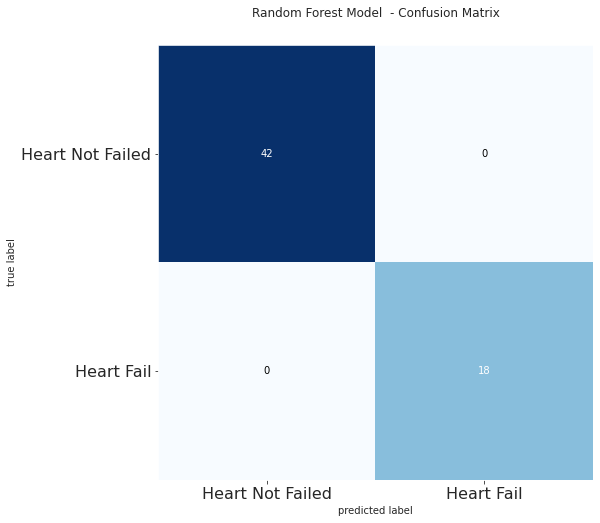

In [176]:
# check Random Forest result
cm_rf = confusion_matrix(y_test, r_pred)
plt.figure()
plot_confusion_matrix(cm_rf, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model  - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [177]:
# GradientBoostingClassifier

gradientboost_clf = GradientBoostingClassifier(max_depth=4, random_state=4)
gradientboost_clf.fit(x_train,y_train)
gradientboost_pred = gradientboost_clf.predict(x_test)
gradientboost_acc = accuracy_score(y_test, gradientboost_pred)
accuracy_list.append(100*gradientboost_acc)
print(Fore.GREEN + "Accuracy of Gradient Boosting is : ", "{:.2f}%".format(100* gradientboost_acc))


Accuracy of Gradient Boosting is :  100.00%


<Figure size 1440x576 with 0 Axes>

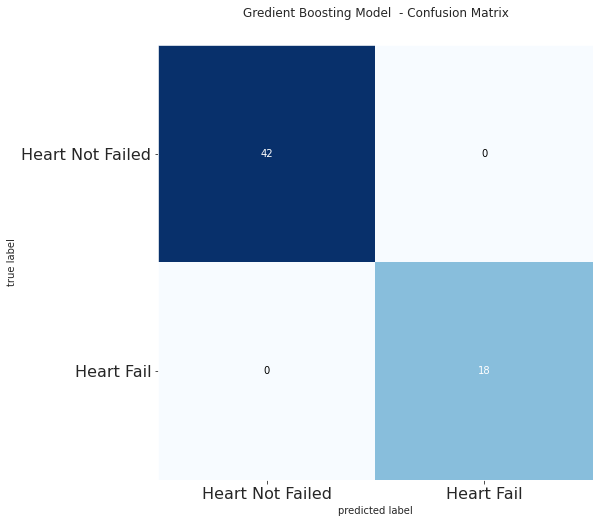

In [178]:
# check Gradient Boosting result

cm_gb = confusion_matrix(y_test, gradientboost_pred)
plt.figure()
plot_confusion_matrix(cm_gb, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model  - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [179]:
# xgbrf classifier

xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=4)
xgb_clf.fit(x_train,y_train)
xgb_pred = xgb_clf.predict(x_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
accuracy_list.append(100*xgb_acc)
print(Fore.GREEN + "Accuracy of XGBRFClassifier is : ", "{:.2f}%".format(100* xgb_acc))


Accuracy of XGBRFClassifier is :  100.00%


<Figure size 1440x576 with 0 Axes>

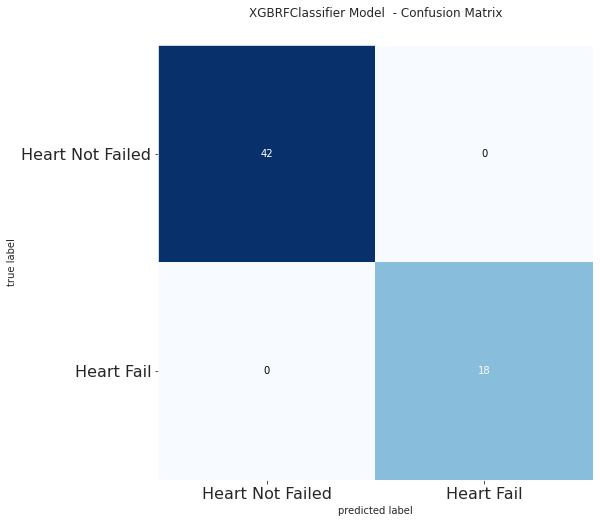

In [180]:
# check xgboost result

cm_xgb = confusion_matrix(y_test, xgb_pred)
plt.figure()
plot_confusion_matrix(cm_xgb, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("XGBRFClassifier Model  - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()


In [181]:
#  lightgbm 


lgb_clf = lightgbm.LGBMClassifier(max_depth=3, random_state=4)
lgb_clf.fit(x_train,y_train)
lgb_pred = lgb_clf.predict(x_test)
lgb_acc = accuracy_score(y_test, lgb_pred)
accuracy_list.append(100*lgb_acc)
print(Fore.GREEN + "Accuracy of LGBMClassifier is : ","{:.2f}%".format(100* lgb_acc))

Accuracy of LGBMClassifier is :  100.00%


<Figure size 1440x576 with 0 Axes>

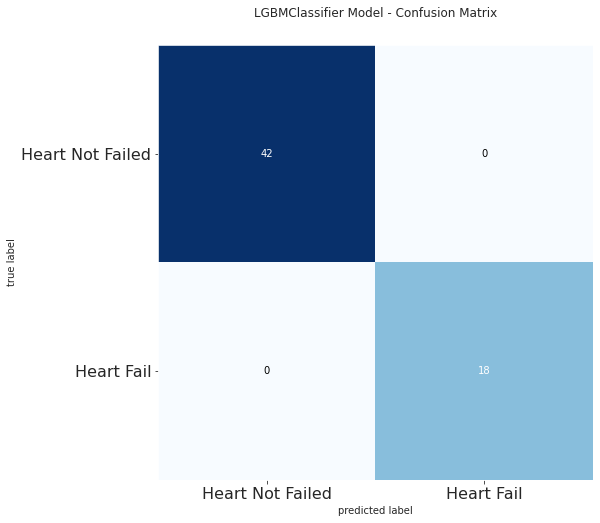

In [182]:
# check lightgbm result

cm_lgbm = confusion_matrix(y_test, lgb_pred)
plt.figure()
plot_confusion_matrix(cm_lgbm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("LGBMClassifier Model - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

In [183]:
# adaboost

adab_clf = AdaBoostClassifier(base_estimator=None , n_estimators=50, learning_rate=1.0, algorithm='SAMME.R',random_state=4)
adab_clf.fit(x_train,y_train)
adab_pred = adab_clf.predict(x_test)
adab_acc = accuracy_score(y_test, adab_pred)
accuracy_list.append(100*adab_acc)
print(Fore.GREEN + "Accuracy of Adaboost Classifier  is : ","{:.2f}%".format(100* adab_acc))


Accuracy of Adaboost Classifier  is :  100.00%


<Figure size 1440x576 with 0 Axes>

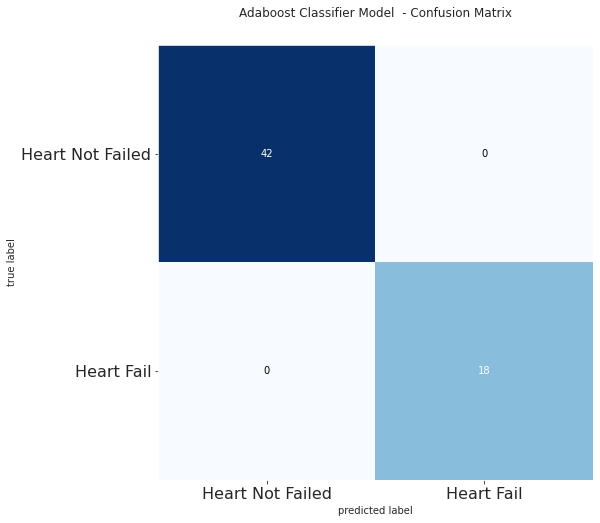

In [184]:
# check Adaboost Classifier result

cm_adab = confusion_matrix(y_test, adab_pred)
plt.figure()
plot_confusion_matrix(cm_adab, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Adaboost Classifier Model  - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=16)
plt.show()

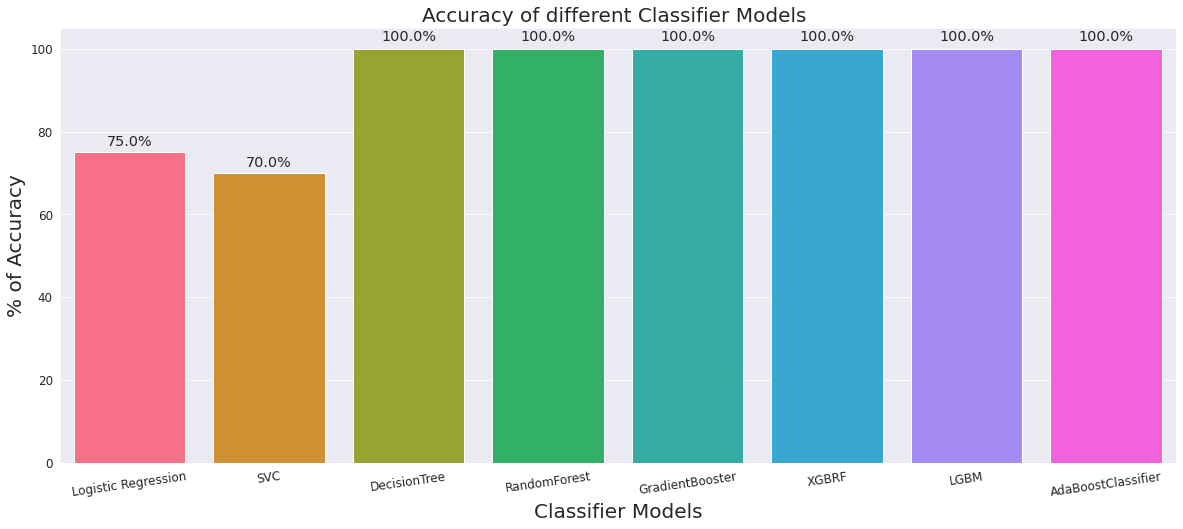

In [185]:
model_list = ['Logistic Regression', 'SVC', 'DecisionTree', 'RandomForest','GradientBooster', 'XGBRF','LGBM', 'AdaBoostClassifier']
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different Classifier Models ', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

